In [1]:
import matplotlib.pyplot as plt
import numpy as np
#import qutip as qt
#from scipy import ndimage, misc
#from ifigures import *
#from ifigures.my_plots import *
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.linalg import kron, eig
import time

In [2]:
import matplotlib.colors as mcolors
import colorsys


#: Durham colour scheme
cDUp = "#7E317B"  # Palatinate Purple
cDUpp =  "#D8ACF4"  # Light purple

cDUb = "#006388"  # Blue
cDUbb = "#91B8BD"  # Mid Blue
cDUbbb = "#C4E5FA"  # Light Blue
cDUbbbb = "#00AEEF"

cDUsky = "#A5C8D0"  # sky blue

cDUo = "#9FA161"  # Olive Green

cDUr = "#AA2B4A"  # Red
cDUrr = "#BE1E2D"
cDUy = "#E8E391" #  Yellow

cDUp = "#C43B8E" # Pink

cDUk = "#231F20"  # Black
cDUkk = "#002A41" # ink

cDUggg = "#CFDAD1"  # Near White/L. Grey
cDUgg = "#968E85"  # Warm Grey
cDUg = "#6E6464"  # midgrey

In [3]:
def make_colormap(seq):
    """
        Args:
            seq: a sequence of floats and RGB-tuples. The floats should be
                increasing and in the interval (0,1).

        Returns:
            a LinearSegmentedColormap
    """
    seq = [(None, ) * 3, 0.0] + list(seq) + [1.0, (None, ) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


c = mcolors.ColorConverter().to_rgb
rvb = make_colormap([
    c('#b20000'),
    c('#fe7600'), 0.125,
    c('#fe7600'),
    c('#feca00'), 0.25,
    c('#feca00'),
    c('#bcfd00'), 0.375,
    c('#bcfd00'),
    c('#06a133'), 0.5,
    c('#06a133'),
    c('#00f6fd'), 0.625,
    c('#00f6fd'),
    c('#000cfe'), 0.75,
    c('#000cfe'),
    c('#e404fe'), 0.875,
    c('#e404fe'),
    c('#b20000')
])


def getColor(amplitude, phase, maxAmplitude):
    c = rvb(phase / (2. * np.pi))
    scale = amplitude / maxAmplitude
    if scale > 1:
        raise ValueError(
            'Amplitude of the passed complex number is bigger than the'
            ' maximal set amplitudeyter not')
    cc = colorsys.rgb_to_hls(c[0], c[1], c[2])
    c = colorsys.hls_to_rgb(cc[0], cc[1] + (1. - scale) * (1. - cc[1]), cc[2])
    return (c[0], c[1], c[2], 1.0)


def getComplexColor(complexNo, maxAmplitude):
    """
    Get color for a complex numbers

    Represents phase as continous colour wheel, and amplitude as intensity
    of color (zero amplitude = white color), with linear mapping in between.

    Args:
        complexNo (complex float): complex number
        maxAmplitude (float): maximum amplitude in the data set we want to
            represent as colour mapped dots. This is used for normalizing color
            intensity, going from maximal saturation or `maxAmplitude` to
            white color for zero amplitude.

    Returns:
        color as [red, green, blue, alpha]
    """
    angle = np.angle(complexNo)
    if angle < 0:
        angle += 2 * np.pi
    return getColor(np.absolute(complexNo), angle, maxAmplitude)

def white_to_transparency(img):
    """
        Converts white areas of image to transprancy.
    """
    x = np.asarray(img.convert('RGBA')).copy()

    x[:, :, 3] = (255 * (x[:, :, :3] != 255).any(axis=2)).astype(np.uint8)

    return Image.fromarray(x)


In [4]:
def TwoQubits(psi0,Omega,Delta,V,tmax,npts):
    rho = (1.0+1.0j)*np.zeros((4,4,npts))    
    Omeff=np.sqrt(Omega**2+Delta**2)
        
    phiL=1.0*np.pi/2
    H1=np.array([[Delta/2, (Omega/2)*np.exp(-1.j*phiL)],[(Omega/2)*np.exp(1.j*phiL), -Delta/2] ])
    I2=np.eye(2,2)
    H2=kron(H1,I2)+kron(I2,H1)
    H2[3,3]=V

    evals, evecs = eig(-1.j*H2)
    evecs=np.mat(evecs)
    for i in range(0,npts):
        psi=evecs*np.mat(np.diag(np.exp(evals*t[i])))*np.linalg.inv(evecs)*psi0 # .dot not needed here
        norm=np.sqrt(abs(psi[0])**2+abs(psi[1])**2+abs(psi[2])**2+abs(psi[3])**2)
        psi=psi/norm   # note that   R2*psi_20 gives something different 
        rho[:,:,i]=kron(psi,psi.H)
    return rho

5.060580253601074


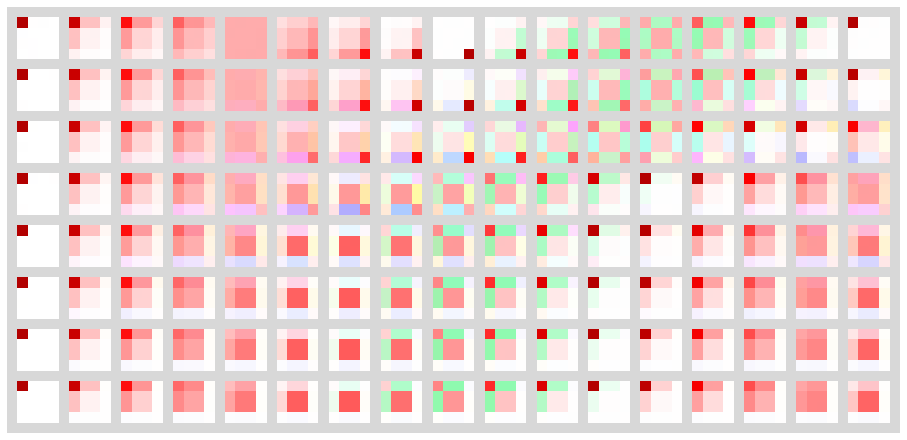

In [10]:
start = time.time()
npts=800
tmax=2.0*np.pi*1
t=np.linspace(0,tmax,npts)
mdim = 4 # matrix dimension
time_dim = 17 # no. of times to plot across rows

#time_dim = 40 # no. of times to plot across rows

parameter_dim = 8 # no. of parameter values down columns

edge = 1

h_dim = time_dim*(mdim+1) + edge
v_dim = parameter_dim*(mdim+1) + edge

R=0.85*np.ones((v_dim,h_dim))
G=0.85*np.ones((v_dim,h_dim))
B=0.85*np.ones((v_dim,h_dim))

fig, ax=plt.subplots(figsize=(16, 8))


for v_index in range(0, parameter_dim): # v_index is no. of rows    
    V=2**(v_index)-1
    psi0=np.mat([[1.0],[0.0],[0.0],[0.0]])
    Delta=0.0
    Omega=5.0+0.000001
    rho = TwoQubits(psi0,Omega,Delta,V,tmax,npts)
    for h_index in range(0, time_dim): # h_index is no. of columns
        t_index=10*h_index        
        for col in range (0,mdim):
            for row in range (0,mdim):
                R[(mdim+1)*v_index+1+row,(mdim+1)*h_index+edge+col]=getComplexColor(rho[row,col,t_index],1.)[0]
                G[(mdim+1)*v_index+1+row,(mdim+1)*h_index+edge+col]=getComplexColor(rho[row,col,t_index],1.)[1]
                B[(mdim+1)*v_index+1+row,(mdim+1)*h_index+edge+col]=getComplexColor(rho[row,col,t_index],1.)[2]

RGB=np.dstack((R, G, B))
    
plt.imshow(RGB)

#plt.arrow(time_dim*(mdim+1)/2 + edge, parameter_dim*(mdim+1) + edge/2, 20, 0, width = 1, head_width = 2, head_length = 4, linewidth = 0, color = cDUkk)
#plt.text(time_dim*(mdim+1)/2 + edge - 20, parameter_dim*(mdim+1) + edge/2 + 1, 'time', fontsize = 48, color = cDUkk)
#plt.arrow(edge/2 - 2, parameter_dim*(mdim+1)/2 - 2, 0, 10, width = 1, head_width = 2, head_length = 4, linewidth = 0, color = cDUkk)
#plt.text(edge/2 - 4, parameter_dim*(mdim+1)/2 - 5, '$V_{\\rm vdW}$', fontsize = 48, rotation = -90, color = cDUkk)


ax.set_axis_off() 

#plt.show()


plt.savefig('Blockade_0.png',bbox_inches='tight',dpi = 300)


end = time.time()
print(end - start)

4.190490007400513


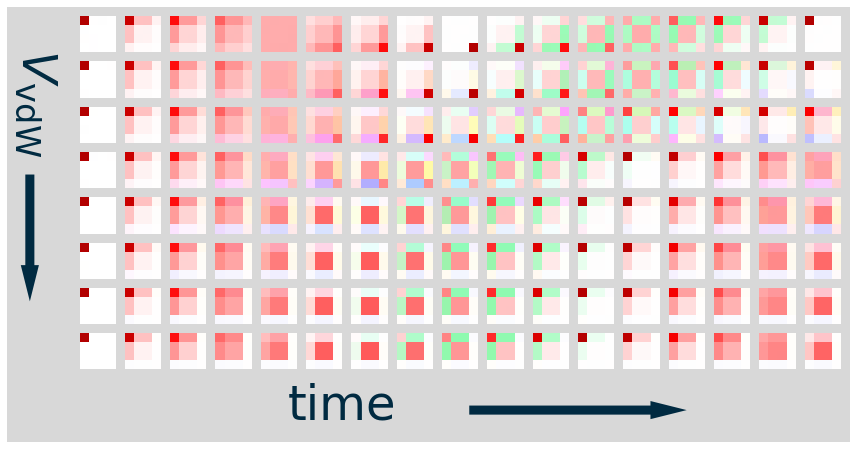

In [11]:
start = time.time()
npts=800
tmax=2.0*np.pi*1
t=np.linspace(0,tmax,npts)
mdim = 4 # matrix dimension
time_dim = 17 # no. of times to plot across rows

#time_dim = 40 # no. of times to plot across rows

parameter_dim = 8 # no. of parameter values down columns

edge = 8

h_dim = time_dim*(mdim+1) + edge
v_dim = parameter_dim*(mdim+1) + edge

R=0.85*np.ones((v_dim,h_dim))
G=0.85*np.ones((v_dim,h_dim))
B=0.85*np.ones((v_dim,h_dim))

fig, ax=plt.subplots(figsize=(16, 8))


for v_index in range(0, parameter_dim): # v_index is no. of rows    
    V=2**(v_index)-1
    psi0=np.mat([[1.0],[0.0],[0.0],[0.0]])
    Delta=0.0
    Omega=5.0+0.000001
    rho = TwoQubits(psi0,Omega,Delta,V,tmax,npts)
    for h_index in range(0, time_dim): # h_index is no. of columns
        t_index=10*h_index        
        for col in range (0,mdim):
            for row in range (0,mdim):
                R[(mdim+1)*v_index+1+row,(mdim+1)*h_index+edge+col]=getComplexColor(rho[row,col,t_index],1.)[0]
                G[(mdim+1)*v_index+1+row,(mdim+1)*h_index+edge+col]=getComplexColor(rho[row,col,t_index],1.)[1]
                B[(mdim+1)*v_index+1+row,(mdim+1)*h_index+edge+col]=getComplexColor(rho[row,col,t_index],1.)[2]

RGB=np.dstack((R, G, B))
    
plt.imshow(RGB)



plt.arrow(time_dim*(mdim+1)/2 + edge, parameter_dim*(mdim+1) + edge/2, 20, 0, width = 1, head_width = 2, head_length = 4, linewidth = 0, color = cDUkk)
plt.text(time_dim*(mdim+1)/2 + edge - 20, parameter_dim*(mdim+1) + edge/2 + 1, 'time', fontsize = 48, color = cDUkk)

plt.arrow(edge/2 - 2, parameter_dim*(mdim+1)/2 - 2, 0, 10, width = 1, head_width = 2, head_length = 4, linewidth = 0, color = cDUkk)

plt.text(edge/2 - 4, parameter_dim*(mdim+1)/2 - 5, '$V_{\\rm vdW}$', fontsize = 48, rotation = -90, color = cDUkk)



ax.set_axis_off() 

plt.savefig('Blockade_1.png',bbox_inches='tight',dpi = 300)


end = time.time()
print(end - start)